# Assignment 7: Twitter Topic Modeling with Non-negative Matrix Factorization.

*Content/Trigger Warning: This assignment uses real-world data from Twitter, but that comes at the risk of our dataset containing tweets about sensitive or triggering topics.The tweets in this dataset do not reflect the views of the CSE/STAT 416 course staff. We have tried our best to remove some of the negative content but can only do so much when there are over 100k tweets in our dataset.This assignment should be doable without having to dig into the tweets present and reading about content you don't want to, but we wanted to give you a heads up just in case you do see something you find offensive.*

This week, we will use the techniques for recommender systems in an unexpected way to help us model topics found on Twitter. In this homework you will practice extracting topics from tweets using matrix factorization. This method assumes every tweet is a combination of several topics weighted by their prevailance in the text. This approach in fact finds a low-dimensional representation of the tweets (through the topic weights).

For this assignment, we will be working with tweets about the pandemic from over two years ago when the pandemic recently entered our lives. The dataset is obtained from [Kaggle](https://www.kaggle.com/smid80/coronavirus-covid19-tweets-late-april?select=2020-04-30+Coronavirus+Tweets.CSV) and the preprocessing we have done followed the steps [here](https://www.kaggle.com/satanizer/covid-19-tweets-analysis). For computational speed we will analyze a dataset from one day: April 30, 2020. We encourage you to explore this dataset further and see how topics change over time.

Fill in the cells provided marked `TODO` with code to answer the questions. **Unless otherwise noted, every answer you submit should have code that clearly shows the answer in the output.** Answers submitted that do not have associated code that shows the answer may not be accepted for credit. 

> Copyright ©2021 Valentina Staneva Hunter Schafer.  All rights reserved.  Permission is hereby granted to students registered for University of Washington CSE/STAT 416 for use solely during Spring Quarter 2021 for purposes of the course.  No other use, copying, distribution, or modification is permitted without prior written consent. Copyrights for third-party components of this work must be honored.  Instructors interested in reusing these course materials should contact the author.

---

# Setup

## Data Loading

First let's read the dataset into a data frame and have a look what is there.

In [37]:
import numpy as np
import pandas as pd

In [38]:
### SKIP
text = pd.read_csv('tweets-2020-4-30.csv')
np.random.seed(416)

In [39]:
### edTest(test_load_data) ###

In [40]:
text = text.fillna('') # some rows are nan so replace with empty string
text.tail()

,text
119142,check results sociallydistant airshow weeks sh...
119143,covid sunsets ra sunset rona ronasunsets duskt...
119144,one favorite performances star band lit livemu...
119145,reminder massmedical members weekly member cal...
119146,i’d never thought primark’s origin hq owns sur...


## Note: Some preprocessing

The dataset you have just loaded was actually pre-processed by us. We briefly describe the steps handled already just so you know that there are usually some extra things that need to be done with text data. We show all the code below if you are curious, but you do not need to fully understand these steps.

* Removed tweets not in English. This is a tricky modeling choice, but one that is pretty common for simplicity and accuracy. Like when discussing bias, a better choice would probably to build up separate models for each language. 
* Removed URLs from tweets (not relevant to analysis)
* Make all text lower-case
* Remove all punctuation
* Remove stop-words (e.g., "a", "the", "to") using [NLTK](https://www.nltk.org/).
* Also remove some too frequent terms related to COVID that end up skewing the analysis.

The code for these steps was shown below. The original dataset had extra columns other than just text.

```
# select tweets in English
text = data['text'][data['lang']=='en']

# remove URL links
text = text.apply(lambda x: re.sub(r"https\S+", "", str(x)))

# make lower case
text = text.str.lower()

# remove punctuation
text = text.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# remove stopwords and common COVID terms
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
stop_words.update(['#coronavirus', '#coronavirusoutbreak', 
                   '#coronavirusPandemic', '#covid19', '#covid_19', 
                   '#epitwitter', '#ihavecorona', 'amp', 'coronavirus', 
                   'covid19','covid-19', 'covidー19'])

def remove_stopwords(tweet):
    words = tweet.split()
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)  # Trick to make string separated by spaces

text = text.apply(remove_stopwords)
```

## TF-IDF Matrix

Remember that matrix factorization methods work on matrices of numbers not text so we need to convert the text into a meaningful numeric representation.

Earlier we discussed the Term Frequency-Inverse Document Frequency as a good way to do that since it defines a word weight vector for each document by accounting for the most popular words such as `the` or `a`.  We can extract it using `scikit-learn`.

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer

# create TF-IDF matrix
vectorizer = TfidfVectorizer(max_df=0.95)  # ignore words with very high doc frequency
tf_idf = vectorizer.fit_transform(text['text'])

# exctract also the words so that we know which feature corresponds to which word
feature_names = vectorizer.get_feature_names()

# check out the shape
tf_idf.shape

/usr/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


(119147, 183012)

### 🔍 **Question 1** Counts

Make two variables `num_tweets` and `num_words` that store the number of tweets in our dataset and number of words in our analysis respectively. Use the number of words as the number of features after doing the TF-IDF computation.

In [42]:
### edTest(test_q1_counts) ###

# TODO compute num_tweets and num_words
num_tweets, num_words = tf_idf.shape

# Modeling Tweets with Topics

We will use a particular technique similar to matrix factorization for recommendation to help us model tweets. In particular we will use a model called Non-negative Matrix Decomposition to help us discover topics.

You might be wondering how we can use an approach we taught for recommender systems to model tweets, when there is no notion of recommending a tweet. The idea is to try to create two matrices to describe "Tweet factors" and "Word factors" that will hopefully correspond to distinct topics of discussion. Just like with matrix factorization for recommendation, our hope is that each factor corresponds to a semantically meaningful topic.

### 🔍 **Question 2** NMF

We will use the [NMF](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html) method from `scikit-learn` to extract the topics. 

Set up an NMF model with 5 components and fit it to our TF-IDF data. Use the `fit_transform` as shown in the example for the documentation above to both fit the NMF model and transform our tweet data in one step.

When creating the model, you will want to use the following hyperparameters to ensure you get the same results as us:
* `init='nndsvd'`
* `n_components=5`

When fitting the model, we will fit it on our TF-IDF data which is a matrix of the shape `(num_tweets, num_words)`.

Save your model in a variable called `nmf` and the projected tweets in a variable called `tweets_projected`.

In [43]:
### edTest(test_q2_nmf) ###

from sklearn.decomposition import NMF

# TODO create and fit the model and transform our data
nmf = NMF(n_components=5, init='nndsvd')
tweets_projected = nmf.fit_transform(tf_idf)

### 🔍 **Question 3** Inspecting Components

The topics are stored within the object `nmf.components_`. Investigate this matrix and the `tweets_projected` matrices by printing their values and their shapes. Make sure you undertsand why each one has the shape it does.

Looking at the `nmf.components_` field, does it correspond to the "Tweet factors" or "Word factors" in the terminology of matrix factorization? Save your answer as a string in a variable called `q3`. 

* If you think the answer is Tweet factors, write `q3 = 'tweet'`
* If you think the answer is Word factors, write `  q3 = 'word'`

**Note: The result for this test will be hidden on both EdStem and Gradescope. Please think carefully about your selection.**


In [44]:
### edTest(test_q3_components) ###

# TODO define q3 = ...
q3 = "word"

# Analyzing Topics

We are now interested in inspecting each topic to find the most prevelant or meaningful words for that topic. We'll consider the words with the highest weights for a topic in NMF model to be the most important words for that topic. Recall that the words themselves are stored in a variable called `feature_names`.

### 🔍 **Question 4** Small Example
Before trying to investigate the values in the real data, let's do a small example first to explore how this can be done. You can use the [`argsort()`](https://numpy.org/doc/stable/reference/generated/numpy.argsort.html) to get a list of array indices sorted by the values at those indices; this is useful when you want to use the ordered indices for another purpose. 

In the cell below, we have defined variables `small_words` and `small_weights` that correspond to a made-up example of words with weights from a single topic in NMF. To be specific, the word at index `i` in `small_words` will have weight `small_weights[i]`. You should write code in the cell below to make a new variable `sorted_small_words` that stores a `list` of the words of `small_words` but in sorted order from *largest weight* to *smallest weight*.


*Notes*:
* Pay special attention to the sort order specified by `argsort`. If you need to reverse an `numpy` array stored in a variable `a`, you can write `np.flip(a)` ([np.flip documentation](https://numpy.org/doc/stable/reference/generated/numpy.flip.html)). 
* Like normal, you should not hard code the answer to this problem but write code to make it work (even though you could easily do this example by just writing out the values). We want you to practice this now since in the next few problems you will have to do this on the real-data.

In [45]:
### edTest(test_q4_sorted_small_words) ###

small_words = ['dogs', 'cats', 'axolotl']
small_weights = np.array([1, 4, 2])

#TODO Write code to make sorted_small_words as described above
sorted_indices = np.flip(small_weights.argsort())
sorted_small_words = [small_words[i] for i in sorted_indices]

### 🔍 **Question 5** Words from Topic
We will now generalize the code you wrote for the last section to work on our real dataset.

Write a function `words_from_topic` to extract an ordered list of words in a topic (highest weight first). Please see the documentation provided in the starter function to see a description of the parameters and return.

*Note*: Your solution should look very similar to the last question.

In [46]:
### edTest(test_q5_words_from_topic) ###

def words_from_topic(topic, feature_names):
  """
  Sorts the words by their weight in the given topic from largest to smallest.
  topic and feature_names should have the same number of entries.

  Args:
  - topic (np.array): A numpy array with one entry per word that shows the weight in this topic.
  - feature_names (list): A list of words that each entry in topic corresponds to

  Returns:
  - A list of words in feature_names sorted by weight in topic from largest to smallest. 
  """

  # TODO implement this function
  ordered_words = [feature_names[i] for i in np.flip(topic.argsort())]
  return ordered_words

Once you have implemented the function above,  you should be able to run the cell below that uses your function to print out the top 10 words in each topic.



In [47]:
def print_top_words(components, feature_names, n_top_words):
    """ 
    print_top_words prints the first n_top_words for each topic in components
    """
    for topic_index, topic in enumerate(components):
        ordered_words = words_from_topic(topic, feature_names)
        top_words = ', '.join(ordered_words[:n_top_words])
        print(f'Topic: #{topic_index}: {top_words}')

print_top_words(nmf.components_, feature_names, 10)

Topic: #0: people, lockdown, get, home, stay, like, one, time, know, go
Topic: #1: cases, new, deaths, total, confirmed, reported, number, positive, reports, today
Topic: #2: spread, app, help, selfreporting, symptoms, download, sooner, identify, slow, daily
Topic: #3: us, china, join, trump, let, million, drug, manmade, intelligence, says
Topic: #4: pandemic, health, support, help, crisis, workers, global, news, need, read


## Investigating Tweet
Next let's look at a specific tweet (index 40151) and the individual contributions of the topics. The cell below prints the text of the original tweet and then the value of the tweet after being transformed by our NMF.

In [48]:
index = 40151
print(text.iloc[index]['text'])
print(tweets_projected[index])

attention seattle shoppers grocery stores working hard keep employees customers safe part help slow spread ☑️ limit trips ☑️ respect special shopping hours ☑️ follow socialdistance guidance stores wegotthisseattle
[0.00823661 0.         0.02895533 0.         0.01529455]


### 🔍 **Question 6** Looking at a tweet

Look at the topic values for the tweet above. Which topic (Topic #0 to Topic #4) is it most  associated with? Save your answer in a variable called `q6`.

For this problem, you can hard-code your answer as a number. For example, if you look at the result and believe it is most associated with Topic 0, you could write `q6 = 0`.

Does this tweet make sense to be grouped in a topic with the words shown in the topic word lists you printed in the last problem?

**Note: The result for this test will be hidden on both EdStem and Gradescope. Please make sure you think carefully about the choices.**


In [49]:
### edTest(test_q6_single_tweet) ###

# TODO look at the output above to identify which topic the tweet above is most associated to
q6 = 2

### 🔍 **Question 7** Largest Topic
In our analysis above where we modeled each tweet in 5 topics, which topic has the most tweets strongly associated with it? 

For each tweet, calculate which topic it is most strongly associated with by looking at the topic values for the tweet. If there is ever a tie for the largest topic weight, take the one with the lowest index (although this is unlikely to happen in our dataset).

Save the index of the topic with the most tweets strongly associated with it in a variable called `largest_topic`. The result should be an integer for the index of the largest topic.

*Hint: There is a very efficient way to do this using code like we wrote in HW6, but there are many ways to solve this problem in general*.


In [50]:
### edTest(test_q7_largest_topic) ###

# TODO find index of largest topic
topic_assignments = tweets_projected.argmax(axis=1)
topic_counts = np.bincount(topic_assignments)
largest_topic = topic_counts.argmax()

# Investigating Trends

One benefit of using matrix factorization to a small dimension, is it lets us visualize tweets in this "topic space" to find any interesting groupings. 

Now in our earlier analysis, we modeled each tweet as 5 topics but that is hard to visualize. 

In the next cell, we will make a new NMF model and projected tweets (called `nmf_small` and `tweets_projected_small` respectively) with 3 components instead of 5. Use the same settings for the other parameters as we did earlier.

In [51]:
nmf_small = NMF(n_components=3, init='nndsvd')
tweets_projected_small = nmf_small.fit_transform(tf_idf)

We can investigate the topics in this small model. Unsurprisingly, they seem mostly the same but a couple topics had to merge.

In [52]:
print_top_words(nmf_small.components_, feature_names, 10)

Topic: #0: us, people, pandemic, lockdown, need, get, health, time, home, like
Topic: #1: cases, new, deaths, total, confirmed, reported, number, positive, reports, today
Topic: #2: help, spread, app, selfreporting, symptoms, download, sooner, identify, slow, feel


Now that we have 3 values for each tweet, we can actually plot each tweet in 3D space to see how all the tweets relate to each other. The following cell does exactly that. You don't need to understand all the specifics of how to make a 3D plot, but just note it is using the 3 topic values for each tweet as the x, y, z coordinates

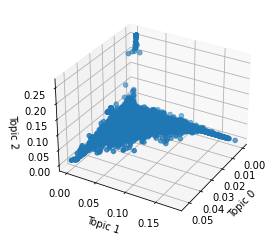

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline

# Set up axes to plot on
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Make 3D scatterplot
ax.scatter(tweets_projected_small[:, 0], tweets_projected_small[:, 1], tweets_projected_small[:, 2])

# Set axis labels
ax.set_xlabel('Topic 0')
ax.set_ylabel('Topic 1')
ax.set_zlabel('Topic 2')

# Rotate plot to be easily viewed
ax.view_init(30, 30)

Interesting, it looks like there is a small cluster of Tweets that are far away from all the others when looking at Topic 2. In other words, there are a few tweets that are very far in the Topic 2 direction while the majority of tweets are spread out more in Topic 0/1.

### 🔍 **Question 8** Outlier Tweets
Let's look into the tweets that seem very different than the rest. 

For this problem, we want you to compute all of the unique tweets (since there are some duplicates) that appear in this region in the "topic space". 

Below, we explain the steps to do this computation. Save your result in a variable called `outlier_tweets` that has type `numpy.array` and stores all the unique tweets that are these outliers (as described below).

For this problem, you should follow these steps:
1. Find which rows in our `tweets_projected_small` are outliers. Based on our visual analysis above, we will define these tweets as ones that have a value of `0.15` or more for Topic 2.
2. Now that we know which rows are outliers, use that information to access the `text` column of our original tweets DataFrame (also called `text`) for those rows.
3. Use the `.unique` function (available on a column of a pandas DataFrame) to find all the unique values (e.g., ignore copy-paste tweets).

If you follow these steps (particularly the last), you will end up with a `numpy.array` with all of the unique tweets that are outliers. Note that many of the tweets look similar, but they count as unique tweets since they have some character differences!

Do you spot a theme amongst these tweets? Do you think there is an explanation why our model isolated them as their own topic?


In [54]:
### edTest(test_q8_outlier_tweets) ###

# TODO implement the process explained above
outlier_mask = tweets_projected_small[:, 2] >= 0.15
outlier_tweets = text[outlier_mask]['text']
outlier_tweets = outlier_tweets.unique()
outlier_tweets

array(['help slow spread identify risk cases sooner selfreporting symptoms daily even feel well 🙏 download app',
       'help slow spread identify risk cases sooner selfreporting symptoms daily even feel well 🙏 download app every little helps',
       'government fails get act together get app help slow spread identify risk cases sooner selfreporting symptoms daily even feel well 🙏 download app',
       'help slow spread identify risk cases sooner selfreporting symptoms daily even feel well 🙏 download app let’s every little helps',
       'help slow spread identify risk cases sooner selfreporting symptoms daily even feel well download app',
       'chance research useful findings already 💪🏼🦠help slow spread identify risk cases sooner selfreporting symptoms daily even feel well 🙏 download app',
       'join millions helping scientists understand spread help slow spread identify risk cases sooner selfreporting symptoms daily even feel well 🙏 download app',
       'youre please consider h